In [274]:
%matplotlib inline
import numpy as np
from time import sleep
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from typing import List
from datetime import date, timedelta

In [296]:
def time_between(d0: date, d1: date):
    return (d1 - d0).days / 365.0

In [306]:
class ForwardPrice:
    """
    An observed price for some delivery day
    """
    def __init__(self, day: date, price: Number):
        self.day = day
        self.price = price
        
    def time_since(self, observation_date):
        return (self.day - observation_date).days / 365.0
        
class ForwardPriceCurve:
    """
    A collection of prices for various delivery times, observed at some time
    """
    def __init__(self, observation_date: date, forward_prices: List[ForwardPrice]):
        self.observation_date = observation_date
        self.forward_prices = forward_prices
        self.delivery_days = [fp.day for fp in self.forward_prices]
        self.last_delivery_day = self.delivery_days[-1]
        self.prices = [fp.price for fp in self.forward_prices]
        self.interpolation_times = [time_between(self.observation_date, d) for d in self.delivery_days]
        
        
    def interpolated_price(self, delivery_date):
        return np.interp(
            time_between(self.observation_date, delivery_date), 
            self.interpolation_times, self.prices
        )
        
    
    def remove_deliveries_expiring_before(self, boundary_date):
        return ForwardPriceCurve(
            self.observation_date,
            [fp for fp in self.forward_prices if fp.day >= boundary_date]
        )
    
    def _draw_curve(self, xs, ys, xlabel):
        fig, ax = plt.subplots()
        line, = ax.plot([])
        ax.xaxis.set_major_formatter(DateFormatter("%b/%y"))
        ax.set_ylim(0, np.max(ys) * 1.2)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("TTF Price")
        line.set_data(xs, ys)
        plt.show()
        
    def draw_absolute_curve(self, initial_date):
        xs = [
            d for d in [self.observation_date + timedelta(i * 30) for i in range(100)]
            if d <= self.delivery_days[-1]
        ]
        ys = [self.interpolated_price(d) for d in xs]
        xtick_dates = [
            d 
            for y in range(2022, 2027) 
            for d in [date(y, 1, 1), date(y, 7, 1)] 
            if initial_date <= d and d <= self.last_delivery_day
        ]
        fig, ax = plt.subplots()
        line, = ax.plot([])
        ax.xaxis.set_major_formatter(DateFormatter("%b/%y"))
        plt.xticks(xtick_dates)
        ax.set_xlim(initial_date, self.last_delivery_day)
        ax.set_ylim(0, 200)
        formatted_observation_date = self.observation_date.strftime("%d %b %y")
        ax.set_xlabel(f"Observation Date {formatted_observation_date}")
        ax.set_ylabel("TTF Price")
        line.set_data(xs, ys)
        plt.show()
        
    def draw_relative_curve(self):
        xs = [fp.time_since(self.observation_date) for fp in self.forward_prices]
        self._draw_curve(xs, self.prices, "Relative time")

        


TTF_28_JAN_PRICES = {
    date(2022, 1, 29):90.50, date(2022, 1, 30):90.50, date(2022, 1, 31):90.70, date(2022, 2, 1):91.07, date(2022, 2, 28):91.07,
    date(2022, 3, 1):90.82, date(2022, 4, 1):87.50, date(2022, 5, 1):86.55, date(2022, 6, 1):86.37, date(2022, 7, 1):86.17,
    date(2022, 8, 1):85.97, date(2022, 9, 1):85.97, date(2022, 10, 1):86.50, date(2022, 11, 1):87.17, date(2022, 12, 1):87.66,
    date(2023, 1, 1):87.85, date(2023, 2, 1):87.83, date(2023, 3, 1):82.82, date(2023, 4, 1):49.50, date(2023, 5, 1):45.50,
    date(2023, 6, 1):44.90, date(2023, 7, 1):44.56, date(2023, 8, 1):44.61, date(2023, 9, 1):44.70, date(2023, 10, 1):44.97,
    date(2023, 11, 1):46.10, date(2023, 12, 1):46.59, 
}

PRICING_DATE = date(2022, 1, 28)
delivery_dates = sorted(TTF_28_JAN_PRICES)
TTF_28_JAN_FPC = ForwardPriceCurve(
    observation_date = PRICING_DATE,
    forward_prices = [ForwardPrice(day=d, price = TTF_28_JAN_PRICES[d]) for d in delivery_dates]
)

In [43]:
from abc import ABC, abstractmethod
from numbers import Number

class PriceProcess(ABC):
    def __init__(self):
        self.rng = np.random.default_rng()
        
    @abstractmethod
    def evolve(fpc: ForwardPriceCurve, next_observation_date: date):
        """ randomly perturb the forward curve"""
  

In [245]:
class LognormalProcessWithExponentialDecay(PriceProcess):
    def __init__(self, alphas: List[Number], vols: List[Number]):
        super().__init__()
        self.alphas = alphas
        self.vols = vols

    def evolve(self, fpc, next_observation_date):
        
        dt = (next_observation_date - fpc.observation_date).days / 365.0
        dzs = [self.rng.normal(scale=np.sqrt(dt)) for _ in range(len(self.alphas))]
        live_fpc = fpc.remove_deliveries_expiring_before(next_observation_date)

        def risk_adj(s):
            return 0.5 * s * s * dt
        
        evolved_prices = []
        for fp in live_fpc.forward_prices:
            evolved_price = fp.price
            time_to_delivery = (fp.day - fpc.observation_date).days / 365.0
            for dz, alpha, vol in zip(dzs, self.alphas, self.vols):
                scaled_vol = np.exp(-alpha * time_to_delivery) * vol
                evolved_price *= np.exp(scaled_vol * dz  - risk_adj(scaled_vol))
            evolved_prices.append(ForwardPrice(fp.day, evolved_price))
            
        return ForwardPriceCurve(
            next_observation_date,
            evolved_prices
        )
                                
        

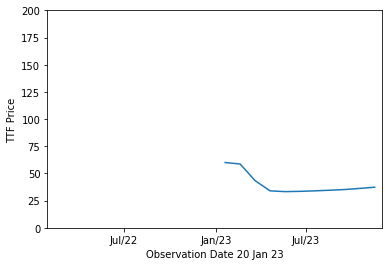

In [308]:
fpc = TTF_28_JAN_FPC
process = LognormalProcessWithExponentialDecay(
    alphas=[0, 0.5, 10],
    vols=[0.2, 0.7, 0.5]
)
observation_days = [PRICING_DATE + timedelta(days=i * 7) for i in range(53)]

for d in observation_days:
    fpc.draw_absolute_curve(PRICING_DATE)
    clear_output(wait=True)
    sleep(0.5)
    fpc = process.evolve(fpc, d)